In [1]:
import hashlib 
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


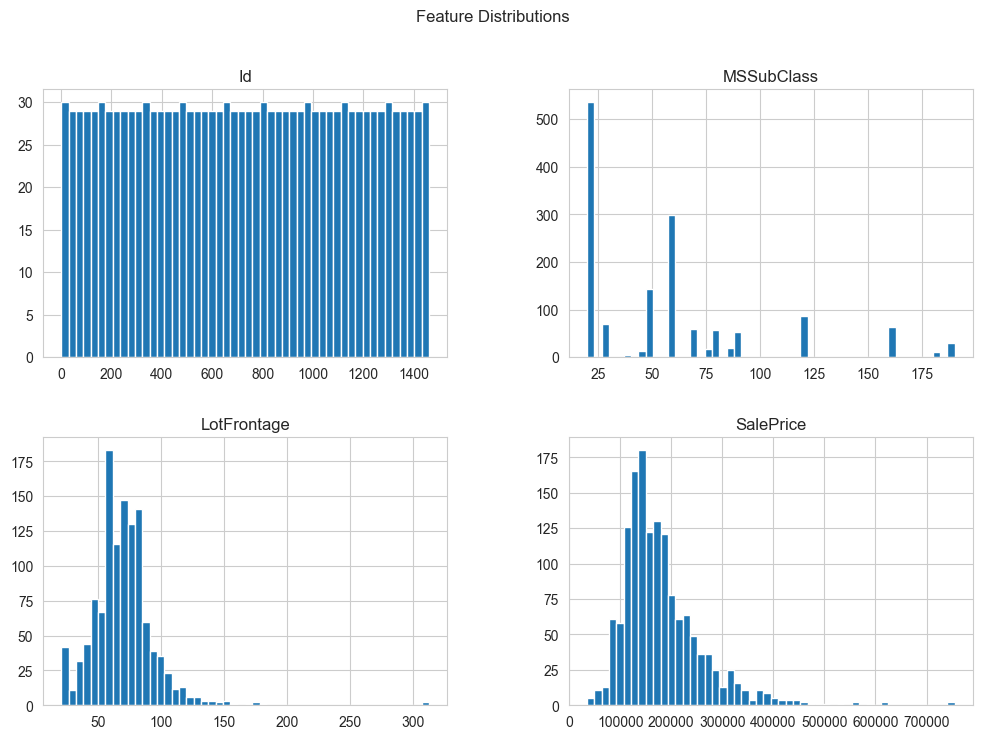

In [3]:
# 数据预览部分
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

# 添加可视化：数据分布直方图
train_data.iloc[:, [0, 1, 2, 3, -3, -2, -1]].hist(bins=50, figsize=(12, 8))
plt.suptitle('Feature Distributions')
plt.show()

In [4]:
# 数据标准化
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

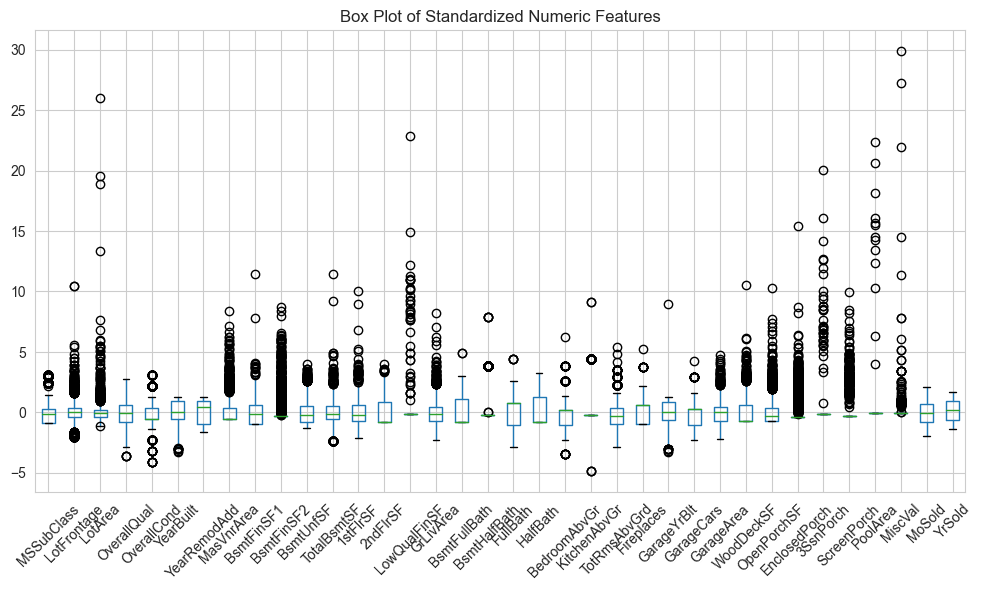

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index 
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) 
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# 添加可视化：标准化后数据的箱线图
plt.figure(figsize=(12, 6))
all_features[numeric_features].boxplot()
plt.title('Box Plot of Standardized Numeric Features')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [6]:
# 独热编码处理
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

# 增加隐藏层和ReLU激活函数
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),  # 第一层隐藏层
        nn.ReLU(),                    # ReLU激活函数
        nn.Linear(128, 64),            # 第二层隐藏层
        nn.ReLU(),                    # ReLU激活函数
        nn.Linear(64, 1)               # 输出层
    )
    return net

In [9]:
# RMSE计算函数
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


In [10]:
# 使用Adam优化器和L2正则化
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


In [11]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [12]:
import matplotlib.pyplot as plt

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            # 修改图表大小与第二张图一致
            plt.figure(figsize=(6, 4))

            # 绘制训练与验证数据曲线
            plt.plot(list(range(1, num_epochs + 1)), train_ls, color='b', linestyle='-', linewidth=2, label='Training')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls, color='g', linestyle='--', linewidth=2, label='Validation')

            # 添加标题与标签
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Log RMSE', fontsize=16)
            plt.title(f'{k}-Fold Cross Validation', fontsize=18, weight='bold')

            # 添加图例、网格与背景颜色
            plt.legend(fontsize=14, loc='upper right')
            plt.grid(True, which='both', linestyle='--', linewidth=0.7)
            plt.gca().set_facecolor('#F5F5F5')  # 使用浅灰色背景

            plt.tight_layout()  # 自动调整边距以避免图表元素重叠

            plt.show()

        print(f'Fold {i+1}, Train RMSE: {train_ls[-1]:.5f}, Validation RMSE: {valid_ls[-1]:.5f}')

    return train_l_sum / k, valid_l_sum / k



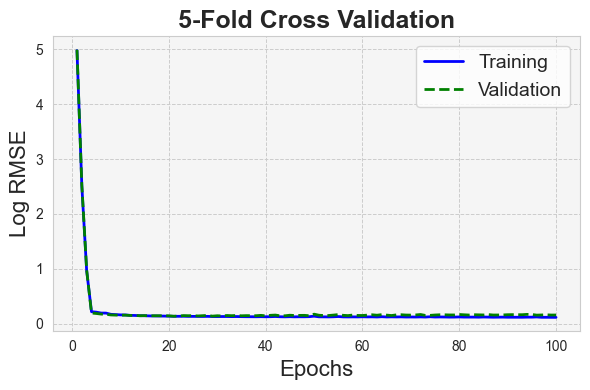

Fold 1, Train RMSE: 0.11524, Validation RMSE: 0.15786
Fold 2, Train RMSE: 0.10849, Validation RMSE: 0.16499
Fold 3, Train RMSE: 0.11188, Validation RMSE: 0.15598
Fold 4, Train RMSE: 0.11969, Validation RMSE: 0.15357
Fold 5, Train RMSE: 0.10212, Validation RMSE: 0.15862
5-fold validation: average train RMSE: 0.11149, average valid RMSE: 0.15820


In [13]:
# 训练设置
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.01, 64
train_l_sum, valid_l_sum = 0, 0
for i in range(k):
    net = get_net()
    data = get_k_fold_data(k, i, train_features, train_labels)
    train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    
    if i == 0:
        plt.figure(figsize=(6, 4))
        plt.plot(list(range(1, num_epochs + 1)), train_ls, color='b', linestyle='-', linewidth=2, label='Training')
        plt.plot(list(range(1, num_epochs + 1)), valid_ls, color='g', linestyle='--', linewidth=2, label='Validation')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Log RMSE', fontsize=16)
        plt.title(f'{k}-Fold Cross Validation', fontsize=18, weight='bold')
        plt.legend(fontsize=14, loc='upper right')
        plt.grid(True, which='both', linestyle='--', linewidth=0.7)
        plt.gca().set_facecolor('#F5F5F5')
        plt.tight_layout()
        plt.show()

    print(f'Fold {i+1}, Train RMSE: {train_ls[-1]:.5f}, Validation RMSE: {valid_ls[-1]:.5f}')

print(f'{k}-fold validation: average train RMSE: {train_l_sum / k:.5f}, average valid RMSE: {valid_l_sum / k:.5f}')

train log rmse 0.111057


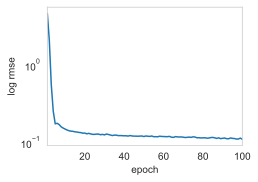

In [14]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
